In [7]:
#100*100 matching market
import numpy as np
import pandas as pd
from scipy.optimize import linear_sum_assignment

# Sample data
donors_names = ['d' + str(i) for i in range(1, 101)]
recipients_names = ['r' + str(i) for i in range(1, 101)]

# Create an initial matching
initial_match = list(zip(donors_names, recipients_names))

# Load preference matrix data
don_pre= pd.read_csv('C:\\Users\\Hongan Li\\Desktop\\Research Project\\Code\\final_code\\preference matrices\\don_pre_100_2.csv', index_col=0)
reci_pre = pd.read_csv('C:\\Users\\Hongan Li\\Desktop\\Research Project\\Code\\final_code\\preference matrices\\reci_pre_100_2.csv', index_col=0)

In [14]:
#20*20 matching market
import numpy as np
import pandas as pd
from scipy.optimize import linear_sum_assignment

# Sample data
donors_names = ['d' + str(i) for i in range(1, 21)]
recipients_names = ['r' + str(i) for i in range(1, 21)]

# Create an initial matching
initial_match = list(zip(donors_names, recipients_names))

# Load preference matrix data
don_pre= pd.read_csv('C:\\Users\\Hongan Li\\Desktop\\Research Project\\Code\\final_code\\preference matrices\\don_pre_20_2.csv', index_col=0)
reci_pre = pd.read_csv('C:\\Users\\Hongan Li\\Desktop\\Research Project\\Code\\final_code\\preference matrices\\reci_pre_20_2.csv', index_col=0)

In [11]:
import random
import math
import matplotlib.pyplot as plt
import time

def find_all_instabilities(matching, reci_pre, don_pre):
    matching_dict = {donor: recipient for donor, recipient in matching}
    instabilities = {}

    for donor, recipient in matching_dict.items():
        # Index of the recipient in the donor's preference list
        matched_recipient_rank = don_pre.loc[donor, recipient]
        donor_preferences = don_pre.loc[donor]

        # Check all recipients above the matched recipient in donor's preferences
        preferred_recipients = donor_preferences[donor_preferences < matched_recipient_rank].index.tolist()

        for other_recipient in preferred_recipients:
            # Find the other donor matched to the other recipient
            other_donor_list = [d for d, r in matching if r == other_recipient]
            if other_donor_list:
                other_donor = other_donor_list[0]

                # If the other recipient prefers this donor over their current match
                if reci_pre.loc[other_recipient, donor] < reci_pre.loc[other_recipient, other_donor]:
                    donor_preference_score = don_pre.loc[donor, other_recipient]
                    recipient_preference_score = reci_pre.loc[other_recipient, donor]
                    instabilities[(donor, other_recipient)] = (donor_preference_score, recipient_preference_score)
    
    return instabilities


def find_undominated_blocking_pair(blocking_pairs, reci_pre, don_pre):
    undominated_pair = None
    best_recipient_score = float('inf')
    best_donor_score = float('inf')
    
    for donor, recipient in blocking_pairs:
        recipient_score = reci_pre.loc[recipient, donor]
        donor_score = don_pre.loc[donor, recipient]
        
        # If the current blocking pair is better than the previous undominated pair
        if (recipient_score < best_recipient_score) or (recipient_score == best_recipient_score and donor_score < best_donor_score):
            best_recipient_score = recipient_score
            best_donor_score = donor_score
            undominated_pair = (donor, recipient)
    
    return undominated_pair

def combine_final_matching(initial_matching, undominated_pair, reci_pre, don_pre):
    new_matching = []
    donor, recipient = undominated_pair

    # Find the current matches of the donor and recipient involved in the undominated pair
    matched_recipient = next(r for d, r in initial_matching if d == donor)
    matched_donor = next(d for d, r in initial_matching if r == recipient)
    
    for d, r in initial_matching:
        if d == donor:
            new_matching.append((d, recipient))
        elif d == matched_donor:
            new_matching.append((d, matched_recipient))
        else:
            new_matching.append((d, r))
    
    return new_matching

In [12]:
def calculate_penalty(matching, reci_pre, don_pre):
    instabilities = find_all_instabilities(matching, reci_pre, don_pre)
    return len(instabilities), instabilities

def neighbor2(current_solution, reci_pre, don_pre):
    current_penalty, current_instabilities = calculate_penalty(current_solution, reci_pre, don_pre)
    
    # If current solution is stable or there are no blocking pairs, return it
    if current_penalty == 0:
        return current_solution

    blocking_pairs = list(current_instabilities.keys())
    if not blocking_pairs:
        return current_solution

    # Find an undominated blocking pair
    undominated_pair = find_undominated_blocking_pair(blocking_pairs, reci_pre, don_pre)

    # Generate a new solution by resolving the undominated blocking pair
    new_solution = combine_final_matching(current_solution, undominated_pair, reci_pre, don_pre)
    return new_solution

def simulated_annealing2(matching, reci_pre, don_pre, initial_temperature, cooling_rate, max_iterations):
    current_solution = matching.copy()
    current_temperature = initial_temperature

    # Lists to record temperature and penalty at each iteration
    temperatures = []
    penalties = []

    best_solution = current_solution.copy()
    best_penalty, _ = calculate_penalty(best_solution, reci_pre, don_pre)

    start_time = time.time()

    for iteration in range(max_iterations):
        current_penalty, _ = calculate_penalty(current_solution, reci_pre, don_pre)

        # Record current temperature and penalty
        temperatures.append(current_temperature)
        penalties.append(current_penalty)

        # If current solution is stable, exit loop
        if current_penalty == 0:
            break

        # Generate a new solution using the neighbor function
        new_solution = neighbor2(current_solution, reci_pre, don_pre)

        new_penalty, _ = calculate_penalty(new_solution, reci_pre, don_pre)

        # Decide whether to accept the new solution
        delta_penalty = new_penalty - current_penalty
        acceptance_probability = math.exp(-delta_penalty / current_temperature) if current_temperature > 0 else 0

        if delta_penalty < 0 or random.random() < acceptance_probability:
            current_solution = new_solution.copy()
            if new_penalty < best_penalty:
                best_solution = new_solution.copy()
                best_penalty = new_penalty

        # Cool down
        current_temperature *= cooling_rate

        # Optional: print progress
        # print(f"Iteration {iteration}, Temperature {current_temperature:.5f}, Penalty {current_penalty}")

        if current_temperature < 1e-10:
            break

    end_time = time.time()
    time_taken = end_time - start_time

    # Return the temperature and penalty lists along with the best solution
    return best_solution, best_penalty, temperatures, penalties, time_taken

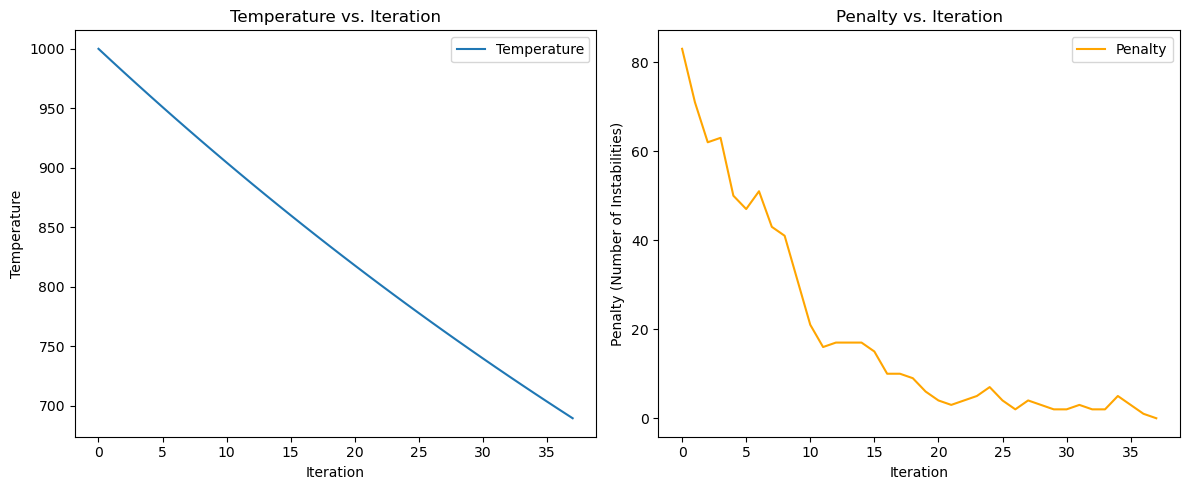

Final Matching: [('d1', 'r11'), ('d2', 'r5'), ('d3', 'r13'), ('d4', 'r8'), ('d5', 'r7'), ('d6', 'r16'), ('d7', 'r4'), ('d8', 'r10'), ('d9', 'r1'), ('d10', 'r12'), ('d11', 'r19'), ('d12', 'r20'), ('d13', 'r6'), ('d14', 'r18'), ('d15', 'r3'), ('d16', 'r2'), ('d17', 'r9'), ('d18', 'r17'), ('d19', 'r15'), ('d20', 'r14')]
Final Penalty: 0
Time Taken: 0.80 seconds


In [15]:
# Run the simulated annealing algorithm and plot the cooling curve and penalty convergence
# Initial parameters
initial_temperature = 1000
cooling_rate = 0.99
max_iterations = 1000
random.seed(0)

# Assuming initial_match, reci_pre, and don_pre are already defined

# Run the simulated annealing algorithm
optimized_matching, final_penalty, temperatures, penalties, time_taken = simulated_annealing2(
    initial_match, reci_pre, don_pre, initial_temperature, cooling_rate, max_iterations)

# Plot the temperature and penalty versus iteration
iterations = list(range(len(temperatures)))

plt.figure(figsize=(12, 5))

# Plot temperature curve
plt.subplot(1, 2, 1)
plt.plot(iterations, temperatures, label='Temperature')
plt.xlabel('Iteration')
plt.ylabel('Temperature')
plt.title('Temperature vs. Iteration')
plt.legend()

# Plot penalty curve
plt.subplot(1, 2, 2)
plt.plot(iterations, penalties, label='Penalty', color='orange')
plt.xlabel('Iteration')
plt.ylabel('Penalty (Number of Instabilities)')
plt.title('Penalty vs. Iteration')
plt.legend()

plt.tight_layout()
plt.show()

# Print final results
print("Final Matching:", optimized_matching)
print("Final Penalty:", final_penalty)
print(f"Time Taken: {time_taken:.2f} seconds")



In [19]:
instabilty = find_all_instabilities(optimized_matching, reci_pre, don_pre)

if instabilty:
    print('The blocking pairs are:')
    for i in instabilty:
        print(i)
else:
    print('The matching is stable.')

The matching is stable.
